# Project 2: Supervised Learning
## Building a Student Intervention System

## 1. Classification vs Regression

Your goal is to identify students who might need early intervention - which type of supervised machine learning problem is this, classification or regression? Why?

---

This is a classic classification problem because we are trying to predict a binary outcome - will the student pass or fail.

---

## 2. Exploring the Data

Let's go ahead and read in the student dataset first.

_To execute a code cell, click inside it and press **Shift+Enter**._

In [1]:
# Import libraries
import warnings
warnings.filterwarnings('ignore') # Suppress seaborn import regarding axes.color_cycle deprecation

import numpy as np
import pandas as pd
import string
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, make_scorer

%load_ext autoreload
%autoreload 2

#plt.style.use('bmh')
%matplotlib inline

In [2]:
# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"
# Note: The last column 'passed' is the target/label, all other are feature columns

Student data read successfully!


Now, can you find out the following facts about the dataset?
- Total number of students
- Number of students who passed
- Number of students who failed
- Graduation rate of the class (%)
- Number of features

_Use the code block below to compute these values. Instructions/steps are marked using **TODO**s._

In [3]:
# TODO: Compute desired values - replace each '?' with an appropriate expression/function call
n_students = student_data.shape[0]
n_features = student_data.shape[1]
n_passed = student_data['passed'].value_counts().loc['yes']
n_failed = student_data['passed'].value_counts().loc['no']
grad_rate = n_passed / float(n_passed + n_failed)
print "Total number of students: {}".format(n_students)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Number of features: {}".format(n_features)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 31
Graduation rate of the class: 0.67%


## 3. Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`'passed'`) is the target or label we are trying to predict.

In [4]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print "Feature column(s):-\n{}".format(feature_cols)
print "Target column: {}".format(target_col)

X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col]  # corresponding targets/labels
print "\nFeature values:-"
print X_all.head()  # print the first 5 rows

Feature column(s):-
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Target column: passed

Feature values:-
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...    

### Preprocess feature columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [5]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all = preprocess_features(X_all)
print "Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Split data into training and test sets

So far, we have converted all _categorical_ features into numeric values. In this next step, we'll split the data (both features and corresponding labels) into training and test sets.

In [6]:
from sklearn.cross_validation import StratifiedShuffleSplit

# First, decide how many training vs test samples you want
num_all = student_data.shape[0]  # same as len(student_data)
num_train = 300  # about 75% of the data
num_test = num_all - num_train

We'll use sklearn's  [StratifiedShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html#sklearn.cross_validation.StratifiedShuffleSplit) to split our data.

A stratified split will ensure that we get a similar distribution of the target variable, 'passed', in both the training and testing sets.

This should be useful if our target y variable is highly unevenly distributed. It should also be slightly helpful in our case of having the contraint of a fairly small training/testing dataset since a 'bad' split with very little variety in the test set could cause poor estimates of model performance.

---

We should also explore the data a little bit to get a feel for the data. We'll also set the seed to make the analysis reproducible. 

We can use the same indices to split the original dataset which didn't contain the dummy variables. This is because we can more easily explore the original training set with plotting libraries.

---

In [7]:
splitGenerator = StratifiedShuffleSplit(y=y_all, 
                                        n_iter=1,
                                        train_size=num_train,
                                        test_size=num_test,
                                        random_state=808)

# Retrieve the next (and only) train/test set indices from the generator.
train_index, test_index = next(iter(splitGenerator))

X_train = X_all.iloc[train_index] 
y_train = y_all.iloc[train_index]
X_test = X_all.iloc[test_index]
y_test = y_all.iloc[test_index]

print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])
# Note: If you need a validation set, extract it from within training data

# Grab the same training rows from the original set for exploring.
X_train_explore = student_data.iloc[train_index]

Training set: 300 samples
Test set: 95 samples


## 2.1 Exploring the Data - Revisited 

Now that we have a testing split pulled out and locked away in vault, let's get a feel for the training data.

We don't want to go exploring the full dataset and risk peeking at our test data and influencing our model selections using any of the test data.

Although note: the training and test data should be distributed roughly the same anyway if we assume they are independent and identically distributed (i.i.d.) and split at random.

It should also be noted that we are not attempting to draw any conclusions about the data, but instead just get a feel for the data. 

In [8]:
from student_intervention_utils import feature_full_names

# Import a helper dictionary mapping a column name to a better description (from the readme.md)
# Use the string library to capitalize words, and deal with apostrophe's
feature_full_names = {key: string.capwords(value) for key, value in feature_full_names.iteritems()}

---

Here, we can plot the counts of the different categorical variables, factored by whether the student passed or not.

---

In [9]:
def plot_counts_categorical(df, count_col='passed', plots_per_row=3):
    
    # Grab all object-type data only
    df_cat = df.select_dtypes(include=['object'])
    
    # Add in the count_col column in case it wasn't included.
    if not (count_col in df_cat.columns):
        df_cat.join(df[count_col])

    for i, col in enumerate(df_cat.columns):
        # Create an index # for each plot. Depends on how many are needed per row.
        plot_index = i % plots_per_row
        
        # If it's the first plot in the row, start a new plot.
        if plot_index == 0:
            f, axes = plt.subplots(1, plots_per_row, figsize=(18, 5))
            sns.despine(left=True)
        
        # Add a countplot to the proper index in plot.
        sns.countplot(data=df, x=col, hue=count_col, ax=axes[plot_index])
        
        # Change the title if it's just a count of one variable, or factored by a second varaible.
        if count_col != col:
            plot_title='Counts of "{0}" \nfactored by "{1}"'.format(feature_full_names[col],
                                                                    feature_full_names[count_col])
        else:
            plot_title = 'Counts of "{0}"'.format(feature_full_names[count_col])
        axes[plot_index].set_title(plot_title)

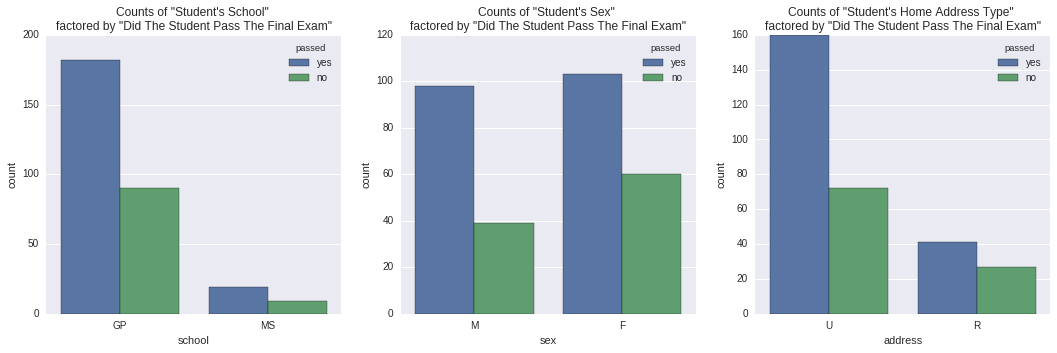

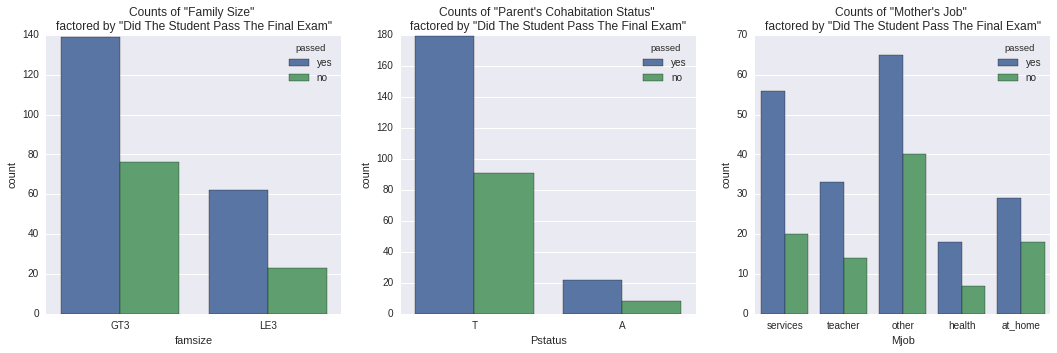

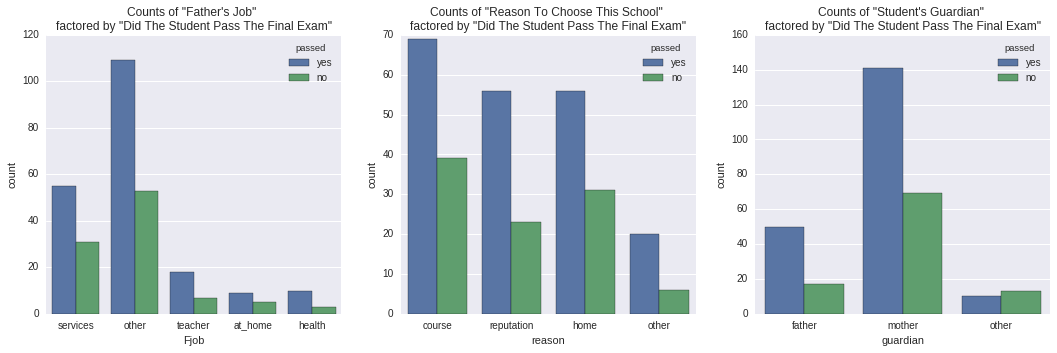

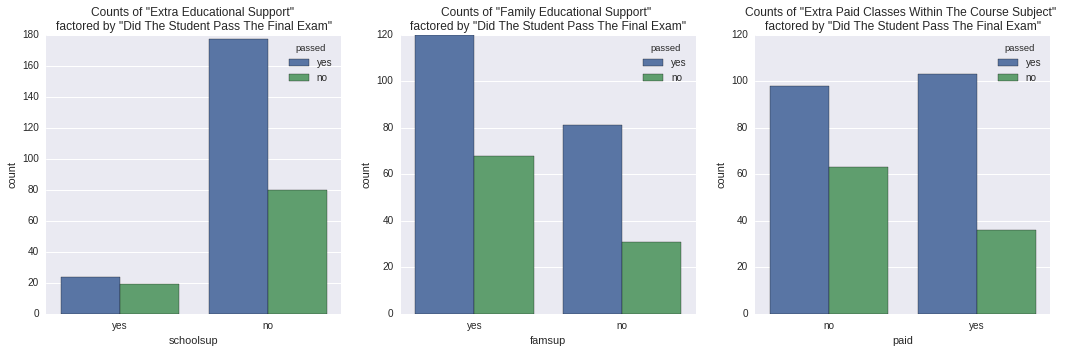

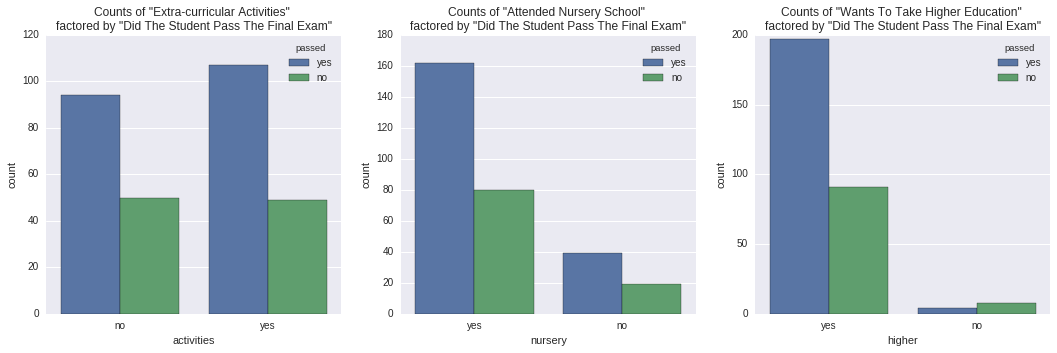

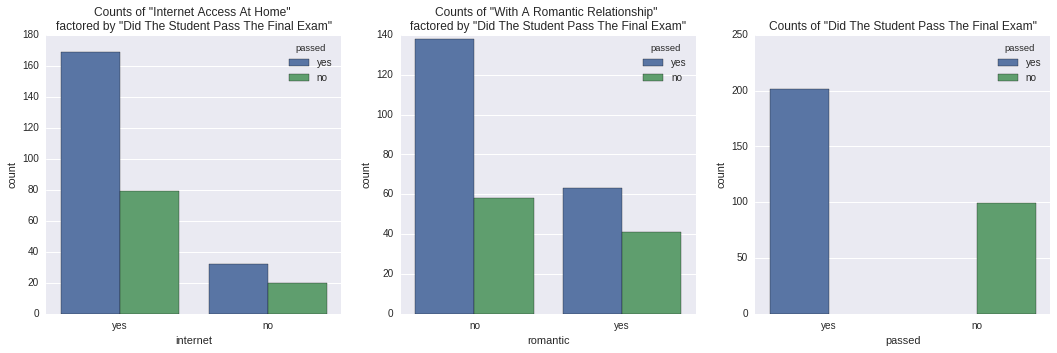

In [10]:
plot_counts_categorical(X_train_explore, count_col='passed', plots_per_row=3)

In most cases, there were not enough students in all of the choices available for each category to draw any meaningful conclusions.

Some distributions did show that there might be differences.

- "Internet access at home"

Those who had access to internet at home, had about twice as many students pass, while those without internet access were fairly close in counts of pass vs fail.

- "With a romantic relationship"

Those not in a romantic relationship seemed to pass relatively more frequently than those in relationships.

"Extra Education Support", "Student's School", and "Wants to take higher education" also showed hints of differing distributions depending on answers, but again, the number of students in each answer were too low to draw any conclusions by eye. 

And again, we are not drawing any conclusions, but perhaps a decision tree clasifier might fair well if pass/fail distributions are different depending on answers to some questions.

Next, let's take at the distriutions of the more continuous numeric variables.

In [11]:
def plot_discrete_numeric_data(df, factor_col='passed', plots_per_row=3):
    
    # Grab all object data only
    df_cat = df.select_dtypes(exclude=['object'])
    
    # Add in the count_col column in case it wasn't included.
    if not (factor_col in df_cat.columns):
        df_cat = df_cat.join(df[factor_col])
    
    # Get rid of the distracting grid; just getting a feel 
    #  for the distributions of pass/fail for each feature.
    sns.set(style="white")
    
    
    for i, col in enumerate(df_cat.columns):
        if col == factor_col:
            continue
        # Create an index # for each plot. Depends on how many are needed per row.
        plot_index = i % plots_per_row
        
        # If it's the first plot in the row, start a new plot.
        if plot_index == 0:
            f, axes = plt.subplots(1, plots_per_row, figsize=(18, 5), sharey=False)
            sns.despine(left=True)
        

        # Separate data into two dataframe, those who passed and those who didn't
        pass_yes = df_cat.loc[df_cat[factor_col] == "yes"]
        yes_label = '{0} - Passed'.format(feature_full_names[col])
        
        pass_no = df_cat.loc[df_cat[factor_col] == "no"]
        no_label = '{0} - Failed'.format(feature_full_names[col])

        # Plot each kernel density plot and overlay them.
        sns.kdeplot(pass_yes[col],
                    ax=axes[plot_index], 
                    shade=True,
                    label=yes_label, 
                    color='#32cd33').set(xlim=(min(pass_no[col]))) # Limit the x-label to the min.
        
        sns.kdeplot(pass_no[col],
                    ax=axes[plot_index], 
                    shade=True, 
                    label=no_label,
                    color='#cd3332').set(xlim=(min(pass_no[col])))   
        
        # Remove y-axes; just getting a feel for the distributions of pass/fail for each feature.
        plt.setp(axes, yticks=[])
        
        # Change the title if it's just a count of one variable, or factored by a second varaible.

        plot_title='Distribution of "{0}" \nfactored by "{1}"'.format(feature_full_names[col],
                                                                feature_full_names[factor_col])

        axes[plot_index].set_title(plot_title)

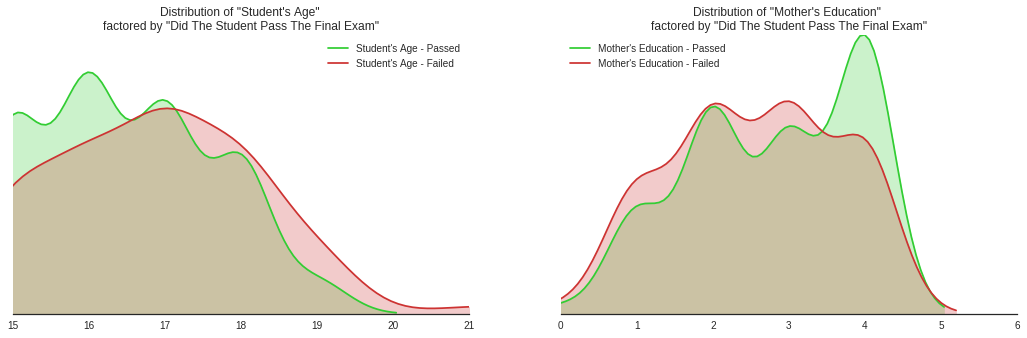

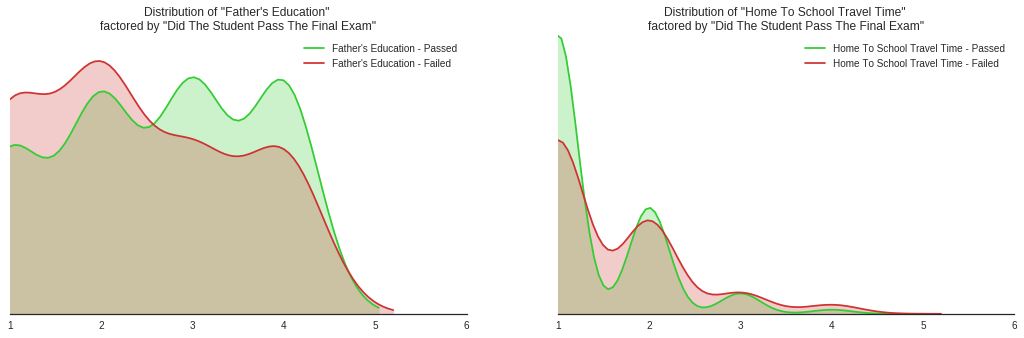

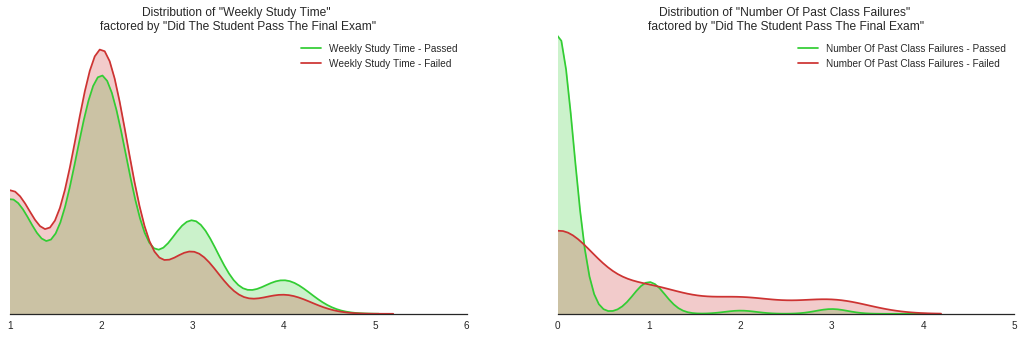

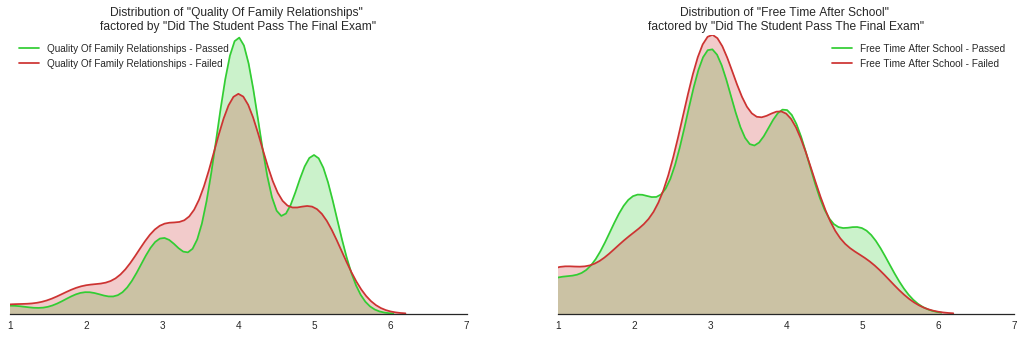

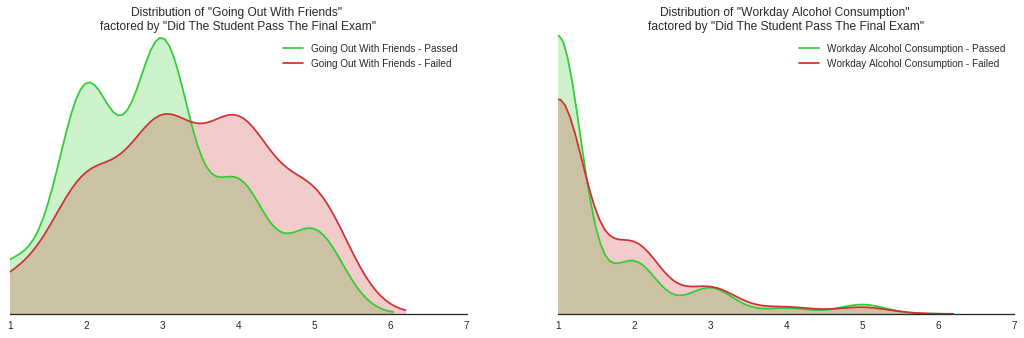

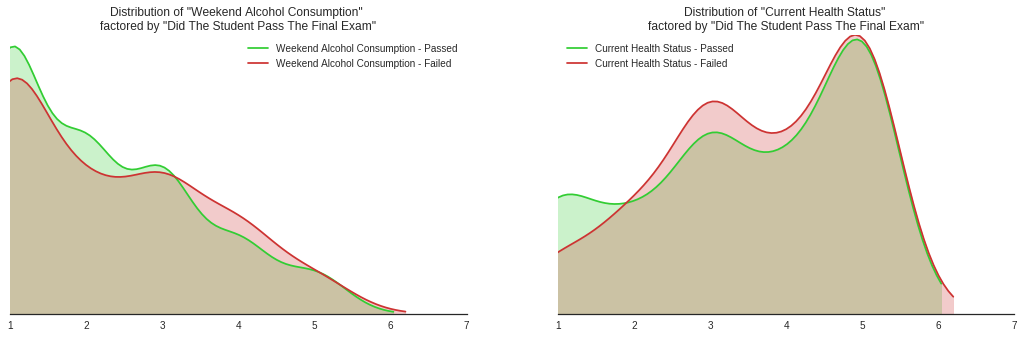

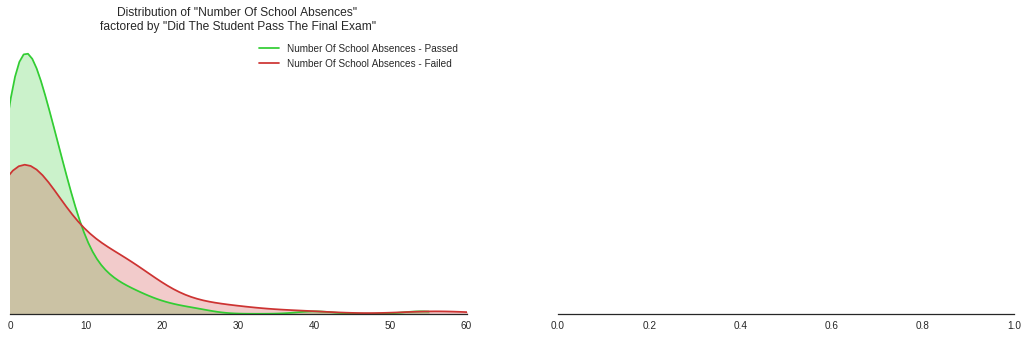

In [12]:
plot_discrete_numeric_data(X_train_explore, factor_col='passed', plots_per_row=2)

Here we can see the estimated probability distributions. A couple stand out as being possibly different for students who passed vs failed.

- "Number of past failures"

Of those students who passed, there was a very high probability of having 0 past failures. But of those failed, there was a more even distribution of probable values between 0-4 times. This is looks to potentially be large indicator of failing.

- "Going out with friends"

Passing students peaked around 2-3 times a week, while the probability mass of failing students centered around 4 times a week.

- "Mother's Education"

Passing students' mothers had a much higher probability mass at 4 (higher education) than non-passing students. Non-passing students' mothers also had a failry higher probability mass at 1 (primary education (4th grade)) than passing students mothers' at 1.

"Student's Age" also shows possible signs of separation among the probability distributions.

---

Again, we can't draw any conclusions, but this also hints at including a decision tree (or nearest-neighbor) based machine learning algorithm for splitting the data based on key variables. 

This would have the added benefit of giving some actionable variables to focus on when attempting to improve passing rate, something that a more opaque machine learning model like a neural net or support vector machine may not be able to provide.

---

## 4. Training and Evaluating Models
Choose 3 supervised learning models that are available in scikit-learn, and appropriate for this problem. For each model:

- What are the general applications of this model? What are its strengths and weaknesses?
- Given what you know about the data so far, why did you choose this model to apply?
- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

Produce a table showing training time, prediction time, F<sub>1</sub> score on training set and F<sub>1</sub> score on test set, for each training set size.

Note: You need to produce 3 such tables - one for each model.

---

If we are simply trying to measure how well a school's changes are doing, pure prediction accuracy/F1 score maximization might be the goal.

For this particular case, I'd argue that maximum prediction accuracy is not our most important goal, but rather inference with high prediction accuracy. 

I'd argue that in this case, we are also trying to provide some actionable items to address to possibly increase the passing rate. In this case, I'd recommend more transparent supervised learning models.

---

### Three Supervised Learning Algorithms

#### Decision Trees

Decision Trees biggest strength is that they are easy to intepret. Decision Trees would give a very direct a simple way to walk down a 'tree' of decision splits at certain features to identify which student's are likely to pass, or be at risk for failure.

Furthermore, they invariant to the scale of features, and "are immune to the effects of predictor outliers" [Hastie et. al (2013).](http://statweb.stanford.edu/~tibs/ElemStatLearn/) They also perform their own internal feature selection, and so become highly resistant to feature variable outliers.

One weakness is that Decision Trees have very high variance since it can grow arbirarily deep. This can cause Decision Trees to (over)fit training data very well, yet predict new data poorly, reducing accuracy.

Cross-validation will be required to get better performance when tuning such parameters as max depth.


#### Random Forests

I would also include the more robust RandomForest model, with feature importance as a measure of important actionable variables. This method would in essence compute many trees, and uncover important features by finding those features that [decrease total node impurity on average over all of the trees computed in the ensemble](http://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined). 

A major strength of Random Forests is their model variance reduction by way of bagging.

##### Bagging

[Bagging](http://statweb.stanford.edu/~tibs/ElemStatLearn/) is a technique which averages many noisy but unbiased models to retain low bias, while reducing variance. In our case, Random Forests will accomplish this by averaging across many Decision Trees. 

http://scott.fortmann-roe.com/docs/BiasVariance.html

In bagging, many replications of the training dataset are made using random sampling with replacement. Each of these datasets are used to build a model and tested on the out-of-samples not used. Then all models vote and their results are averaged together greatly reducing the model variance.

Since each generated tree is identically distributed, the expecation of an average of any number of trees is the same as the expectation of any individual tree. This means that the bias essentially remains the same for any number of bagged trees.

One weakness though is that you do have to grow many more trees. Many tree must be grown, especially if we have many (irrelevant) features since the more irrelevant features we have, the lower the chance of including relevant features in each randomly sampled dataset/tree. We can try to address this by tuning the max_features parameters in a grid search tuning.

This can become a computational problem if using a high K-fold cross-validation procedure in conjunction with a deep parameter grid-search. (Luckliy we can make use of common multi-core processors to speed this up significantly.) 

Another weakness is the slightly loss of interpretability. We can find the most important features, on average, but it is not as simple as a decision tree for identifying exact paths to different groups of target students.

#### Logistic Regression

A third method might be logistic regression with an L1 regularizer to perform a sort of feature selection to keep only the most important variables in the model.

Here we might be able to find the features that can have the most impact on accuracy/F1 score while ignoring less important ones. L1 regularization strength is a parameter to address this in grid search tuning.

A strength is that Logistic Regression (with L1 penalty) is a fairly simple and very highly optimized quadratic programming model, so it should be almost instaneous to train for our datasets.

_(While Logistic Regression has a closed form solution (up to maybe 10,000's of students), including L1 regularization does not.)_

It is also fairly interpretable as we can see negative and positive correlation strengths for relevant features. 

One obvious weakness is that logistic regression assumes passing/failing students are linearly separable by a weighted sum of the features that have been measured. This gives this model fairly low bias, and much less variance than a single Decision Tree.



---

SVM or neural networks might deliver high accuracy as well, but we would only be measuring the prediction accuracy of the given set of measured variables with no concrete idea of what to address to possibly increase the passing rate of future students.

---

For now, our training set is small enough that we might be forgiven for foregoing a validation set and using 5-fold cross-validation in our grid-search in its place.

---


In [13]:
# Train a model
import time

def train_classifier(clf, X_train, y_train, verbose=True):
    
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    train_time = end - start
    
    if verbose:
        print "Trained {}...".format(clf.__class__.__name__)
        print "Training time (secs): {:.4f}".format(train_time)

    return clf, train_time

In [14]:
# Predict on training set and compute F1 score
from sklearn.metrics import f1_score

def predict_labels(clf, features, target, verbose=True):
    
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    
    prediction_time = end - start
    
    if verbose:
        print "Predicted labels using {}...".format(clf.__class__.__name__)
        print "Prediction time (secs): {:.4f}".format(prediction_time)

    return f1_score(target.values, y_pred, pos_label='yes'), prediction_time


In [15]:
# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test, verbose=True):

    clf, train_time = train_classifier(clf, X_train, y_train, verbose=verbose)
    
    F1_train, prediction_time_train = predict_labels(clf, X_train, y_train, verbose=verbose)
    
    F1_test, prediction_time_test = predict_labels(clf, X_test, y_test, verbose=verbose)
    
    if verbose:
        print "------------------------------------------"
        print "Training set size: {}".format(len(X_train))    
        print "F1 score for training set: {}".format(F1_train)
        print "F1 score for test set: {}".format(F1_test)
    
    F1_scores = {'F1_train': F1_train,
                 'F1_test': F1_test}
    
    timings = {'Training_time': train_time,
               'Predict_time_train': prediction_time_train,
               'Predict_time_test': prediction_time_test}
    
    return clf, F1_scores, timings
# TODO: Run the helper function above for desired subsets of training data
# Note: Keep the test set constant

In [16]:
def subset_train_predict(clf, X_train, y_train, X_test, y_test, subset_sizes, verbose=False):
    # http://stackoverflow.com/questions/10715965/add-one-row-in-a-pandas-dataframe

    rows_list = [] # Ininitialize an empty list to hold each row of data for the dataframe

    for i in subset_sizes:
        one_row = {'Training_size': i} # Initialize new row each pass 
        
        X_train_subset = X_train[:i]
        y_train_subset = y_train[:i]
        
        clf, F1_scores, timings = train_predict(clf, X_train_subset, y_train_subset, X_test, y_test, verbose=verbose)
        
        one_row.update(F1_scores) # Update row dictionary with our data
        one_row.update(timings)
        
        rows_list.append(one_row) # Add each row to the list of rows
        
    # Create/return a pandas dataframe with the list of rows 
    # (uses a list comprehension under the hood for speed)
    return pd.DataFrame(rows_list) 

In [17]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.
    
    Args
    ----
    tree -- scikit-learn DecisionTree model.
    feature_names -- list of feature names.
    """
    with open("tree.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        impurity=False,
                        rounded=True,
                        filled=True,
                        leaves_parallel=False,
                        feature_names=feature_names,
                        class_names=['fail', 'pass']) # Corresponds to our [0, 1] y-variables

In [18]:
def computation_time_plot(comp_stat_df):

    fig, ax = plt.subplots(figsize=(12, 9))
    ax.plot(comp_stat_df.Training_size, comp_stat_df.Predict_time_test, label='Prediction Time - Test')
    ax.plot(comp_stat_df.Training_size, comp_stat_df.Predict_time_train, '--', label='Prediction Time - Train')
    ax.plot(comp_stat_df.Training_size, comp_stat_df.Training_time, label='Training Time')    
    legend = ax.legend(loc='best')
    ax.set_xticks(subset_sizes)
    ax.set_xticklabels(subset_sizes, rotation='vertical')
    ax.set_ylabel('Seconds')
    ax.set_xlabel('Training Set Size')
    ax.set_title('Training/Prediction Times')
    plt.show()

In [19]:
def F1_plot(comp_stat_df):

    fig, ax = plt.subplots(figsize=(12, 9))
    ax.plot(comp_stat_df.Training_size, comp_stat_df.F1_test, label='F1 score - Test')
    ax.plot(comp_stat_df.Training_size, comp_stat_df.F1_train, '--', label='F1 score - Train')
    legend = ax.legend(loc='best')
    ax.set_ybound(min(comp_stat_df.F1_test) - 0.05, max(comp_stat_df.F1_train) + 0.05)
    ax.set_xticks(subset_sizes)
    ax.set_xticklabels(subset_sizes, rotation='vertical')
    ax.set_ylabel('F1 Score')
    ax.set_xlabel('Training Set Size')
    ax.set_title('F1 Scores for each sample size training set')
    plt.show()

## Decision Tree

In [20]:
subset_sizes = xrange(100, 301, 10)

tree_stats = subset_train_predict(DecisionTreeClassifier(),
                                         X_train, y_train,
                                         X_test, y_test,
                                         subset_sizes=subset_sizes)

tree_stats

,F1_test,F1_train,Predict_time_test,Predict_time_train,Training_size,Training_time
0,0.717557,1,0.000149,0.000125,100,0.000689
1,0.716667,1,0.000112,0.000117,110,0.000548
2,0.725806,1,0.000114,0.000116,120,0.000611
3,0.724409,1,0.000111,0.000119,130,0.000685
4,0.741935,1,0.000109,0.000116,140,0.000690
5,0.704000,1,0.000106,0.000118,150,0.000719
6,0.683333,1,0.000104,0.000116,160,0.000739
7,0.714286,1,0.001330,0.000129,170,0.000781
8,0.683761,1,0.000113,0.000139,180,0.000890
9,0.698413,1,0.000112,0.000140,190,0.000927


In [157]:
tree_untuned_stats = tree_stats[20:21]

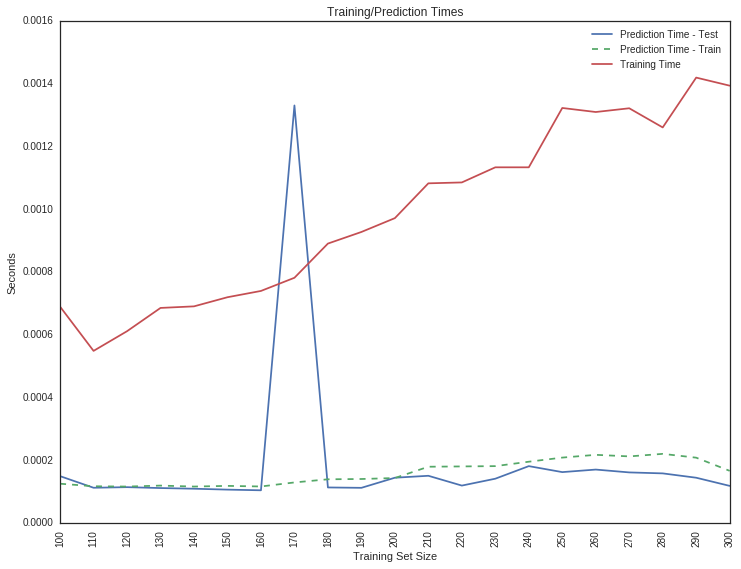

In [21]:
computation_time_plot(tree_stats)

Training time looks to increase fairly linearly as we train the model on more data. Training times are currently in the sub-milliseconds so more training data should have minimal impact on computation and memory requirements for a single computer.

Prediction times stays at negligible values.

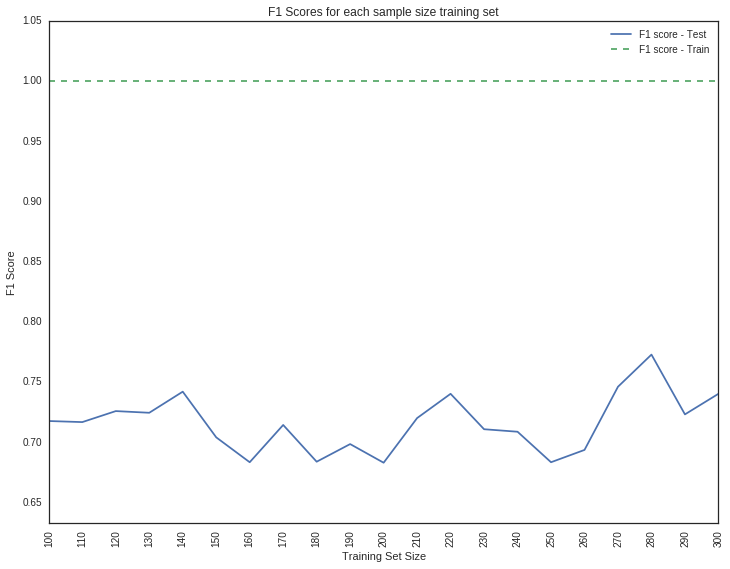

In [22]:
F1_plot(tree_stats)

Test scores seem to get slightly better with more data and should show slightly more of an increase with more proper tuning.

It ended up at around 0.74 F1 score on the full training dataset of 300.

In [23]:
tree_model, _, _ = train_predict(DecisionTreeClassifier(),
                                 X_train, y_train,
                                 X_test, y_test,
                                 verbose=False)

In [24]:
visualize_tree(tree_model, X_train.columns)

In [25]:
%%bash

dot -Tpng tree.dot -o tree.png

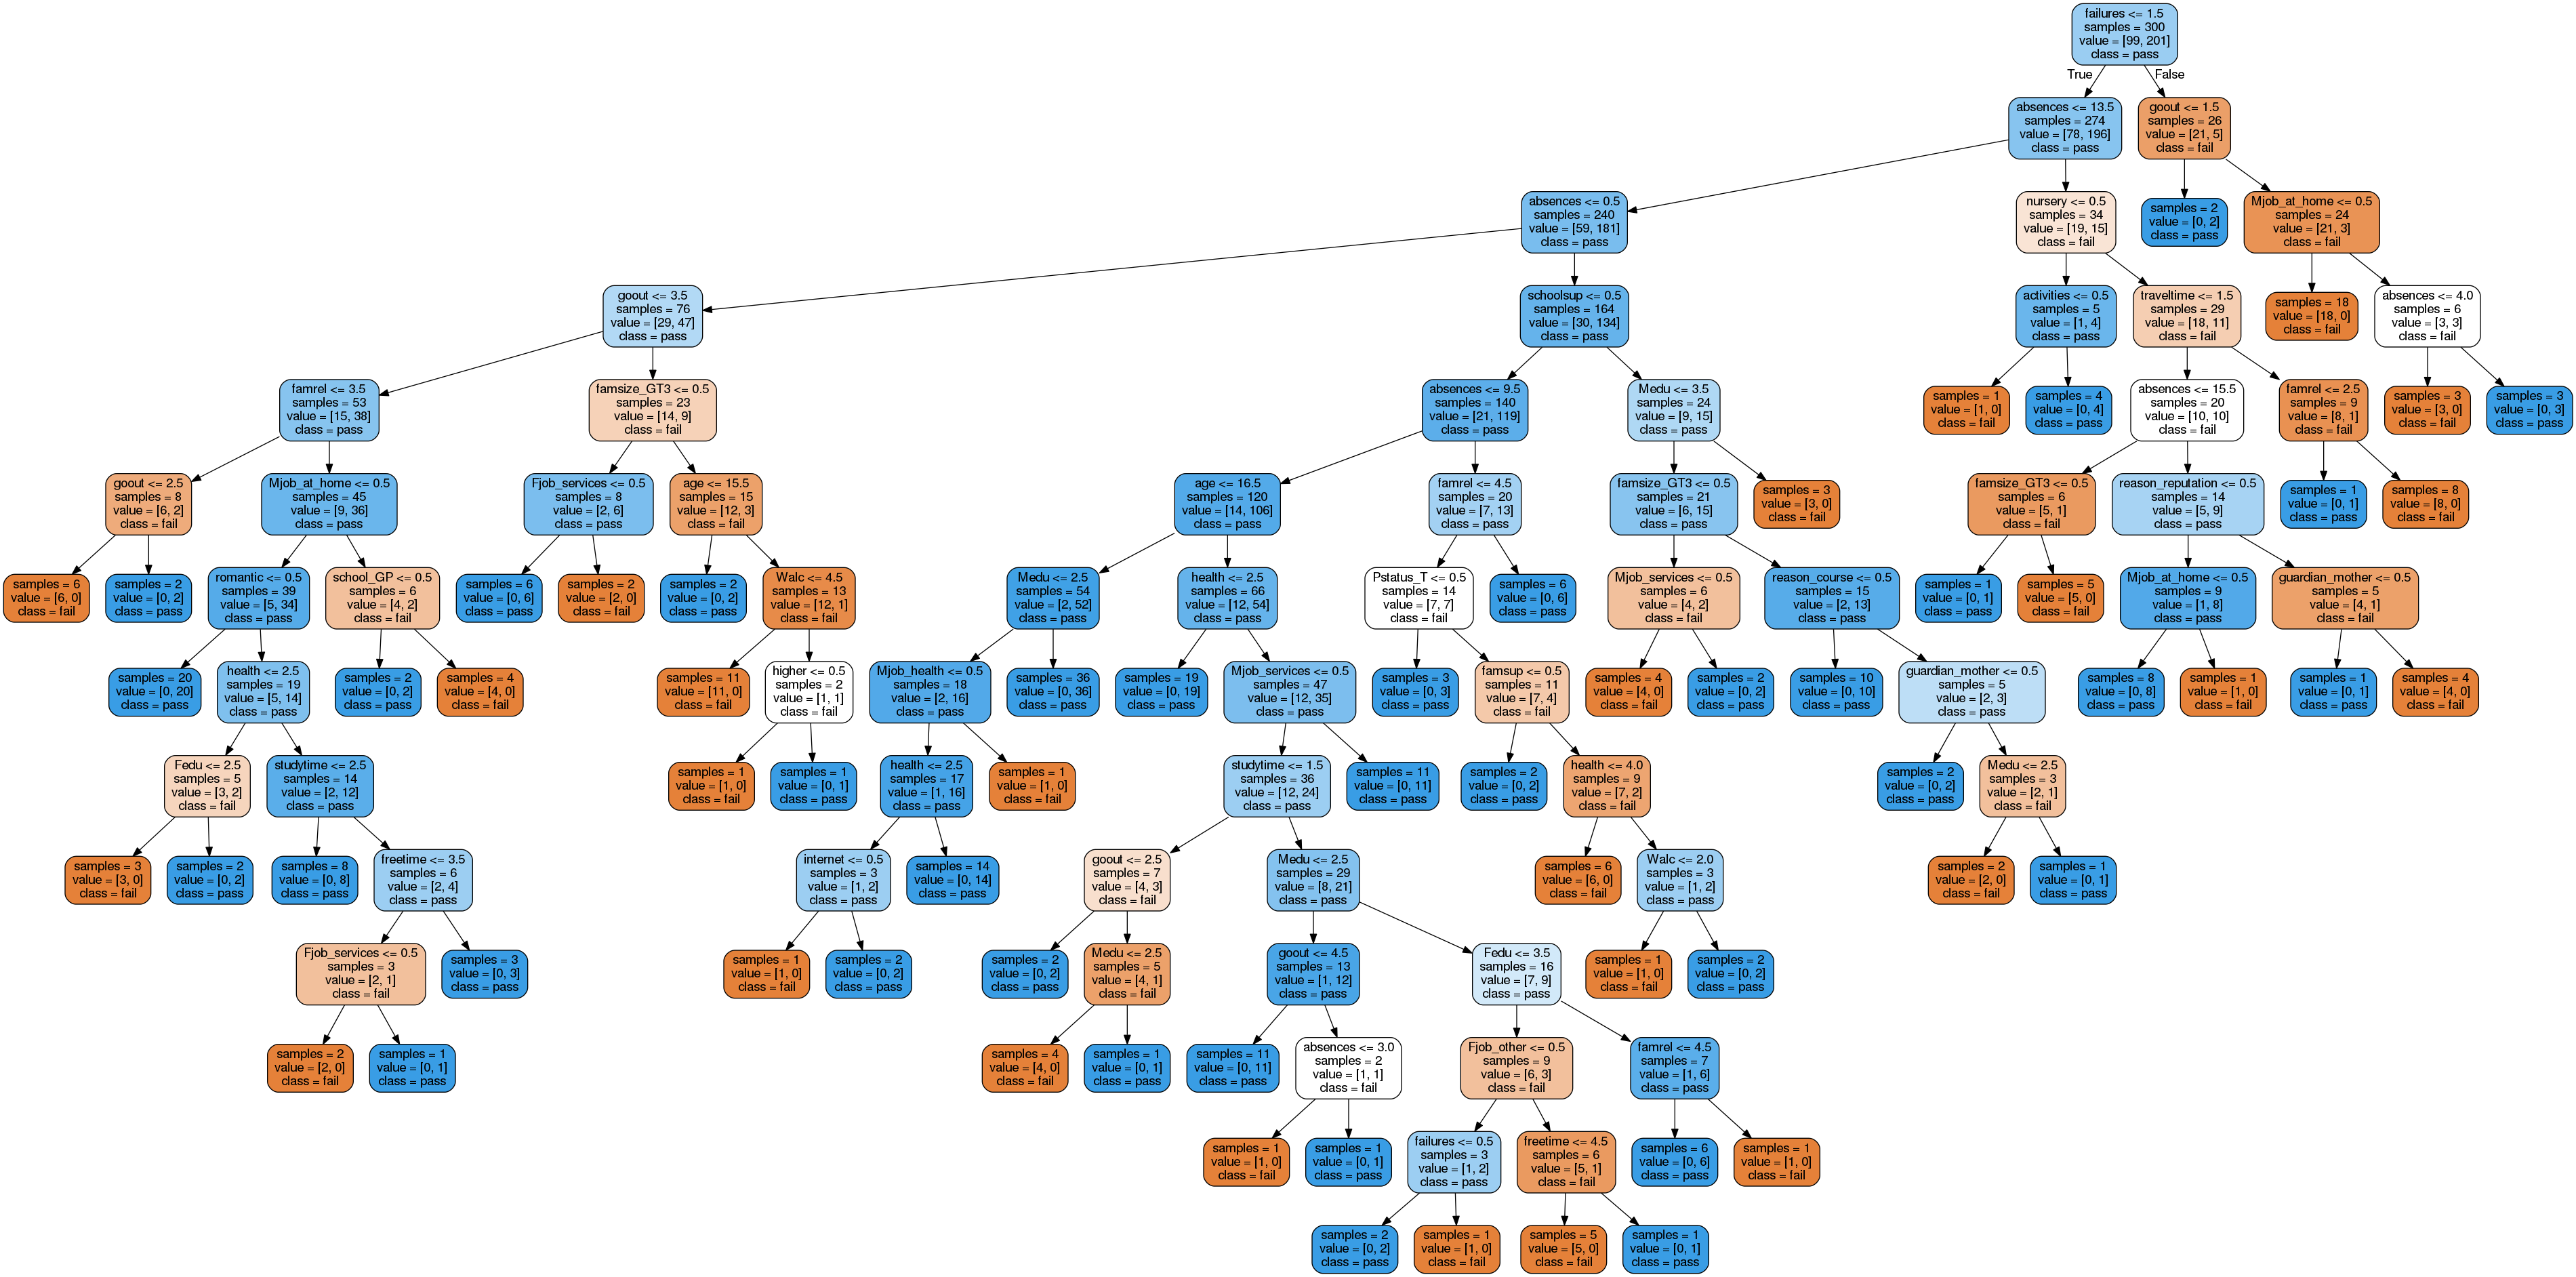

In [26]:
from IPython.display import Image
Image(filename='tree.png', width=920, height=1280)

Here, we can visualize the tree and see that this tree knows the training set extremely well, but will need some tuning to generalize better to unseen data.

By default, our Decision Tree doesn't really have many bounds on how big it can grow to fit the data making it quite large.

## Random Forest

In [145]:
subset_sizes = xrange(100, 301, 10)

rf_stats = subset_train_predict(RandomForestClassifier(),
                                         X_train, y_train,
                                         X_test, y_test,
                                         subset_sizes=subset_sizes)
rf_stats

,F1_test,F1_train,Predict_time_test,Predict_time_train,Training_size,Training_time
0,0.748092,0.992481,0.000752,0.000640,100,0.011755
1,0.766917,0.986667,0.000623,0.000663,110,0.010381
2,0.759690,0.987654,0.000587,0.000658,120,0.010551
3,0.748092,0.994413,0.000637,0.000732,130,0.010564
4,0.700000,0.989583,0.000704,0.000830,140,0.011780
5,0.730159,0.985075,0.000902,0.000844,150,0.013466
6,0.720000,0.986047,0.000621,0.000737,160,0.011457
7,0.770370,0.991228,0.000600,0.000683,170,0.010639
8,0.776119,0.995885,0.000595,0.000691,180,0.010619
9,0.746269,0.996109,0.000597,0.000687,190,0.010624


In [156]:
rf_untuned_stats = rf_stats[20:21]

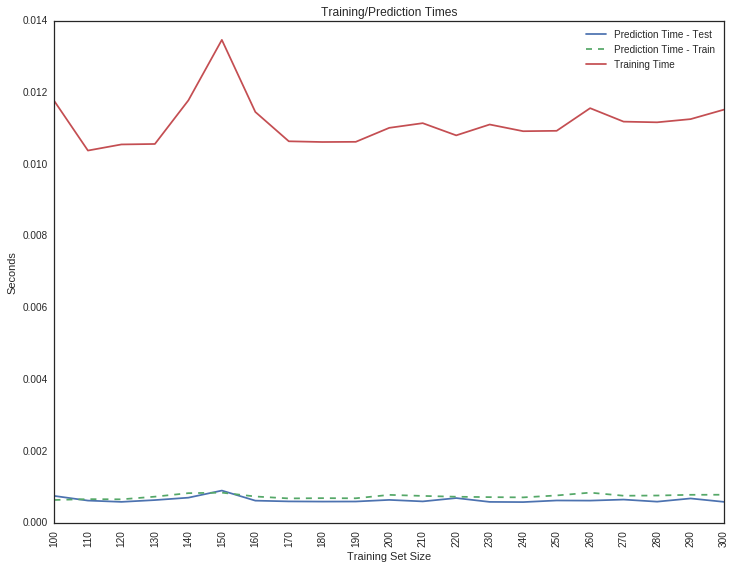

In [146]:
computation_time_plot(rf_stats)

Random Forests are still fast given the size of our dataset, but much slower comparitavely to our other models.

The default trees grown are a paultry 10, so training time should increase as we increase this number to reduce model variance in our grid tuning.

Predictions times though are still negligible.

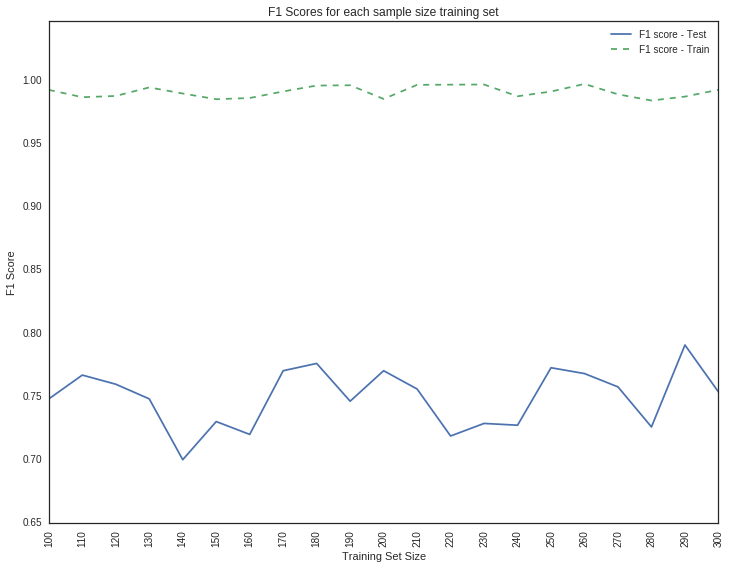

In [147]:
F1_plot(rf_stats)

Our untuned model looks to be stuck vacillating around a  F1 score range of 0.70 to 0.79 on the test data.

It ended up around 0.75 F1 score on the full training dataset of 300.

In [148]:
rf_model, _, _ = train_predict(RandomForestClassifier(),
                               X_train, y_train,
                               X_test, y_test,
                               verbose=False)


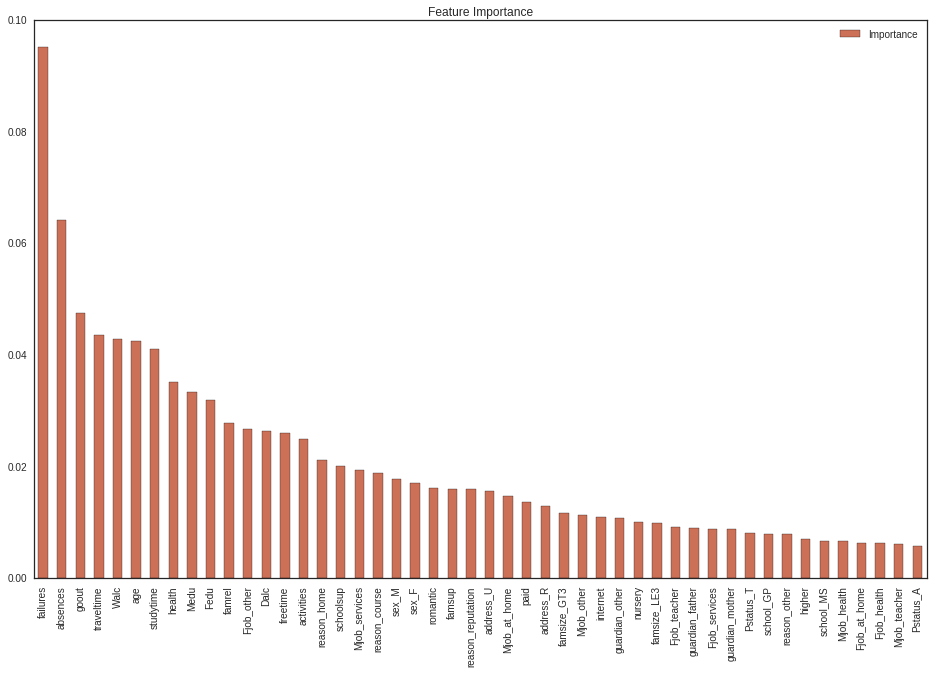

In [149]:
rf_importances = pd.DataFrame({'Feature': X_train.columns, 
                               'Importance': rf_model.feature_importances_}, 
                             index=X_train.columns)

rf_importances.sort_values(by='Importance',
                           ascending=False).plot(kind='bar', 
                                                 figsize=(16, 10),
                                                 color='#cd7058',
                                                 title='Feature Importance')

We can pull out the feature importances and see that many top important variables seem to be the same general ones we noticed in our cursory exploratory plots.

The order of some of the top features might change slightly between training runs, but the same top features stay near the top.

---

## Logistic Regression

For logistic regression, we will [standardize](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) the features by by removing the mean and scaling to unit variance.

>[Standardization](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual feature do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).

>For instance many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the L1 and L2 regularizers of linear models) assume that all features are centered around 0 and have variance in the same order.

>If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

This is so everything is on the same scale when weighting our variables, which could be on vastly different scales (age vs absences vs etc.) and in turn, affect model performance.

This can also help our algorithm avoid under/overflow errors among other things.

In [42]:
scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)


In [47]:
subset_sizes = xrange(100, 301, 10)

lr_stats = subset_train_predict(LogisticRegression(),
                                         X_train_scaled, y_train,
                                         X_test_scaled, y_test,
                                         subset_sizes=subset_sizes)
lr_stats

,F1_test,F1_train,Predict_time_test,Predict_time_train,Training_size,Training_time
0,0.725806,0.934307,0.000089,0.006917,100,0.001560
1,0.694215,0.911392,0.000067,0.000082,110,0.000940
2,0.715447,0.923977,0.000065,0.000085,120,0.000940
3,0.717557,0.903226,0.000072,0.000090,130,0.000920
4,0.761905,0.855721,0.000070,0.000099,140,0.001008
5,0.784000,0.872038,0.000070,0.000130,150,0.001054
6,0.771654,0.868421,0.000069,0.000103,160,0.001123
7,0.769231,0.857143,0.000068,0.000100,170,0.001177
8,0.769231,0.853755,0.000065,0.000091,180,0.001221
9,0.775194,0.851852,0.000067,0.000096,190,0.001405


In [159]:
lr_untuned_stats = lr_stats[20:21]

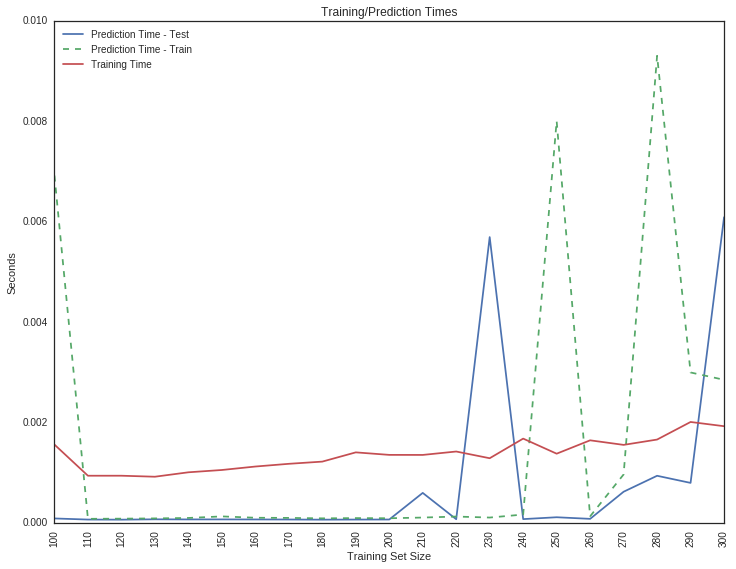

In [48]:
computation_time_plot(lr_stats)

Training time increases linearly with more examples, and is the fastest of the three algorithms at these training set sizes.

Prediction time is so quick on the order of micro-seconds that small fluctuations in the state of our computer can cause it to artificially seem to randomly increase. 

It ended up around 0.768 F1 score on the full training dataset of 300.

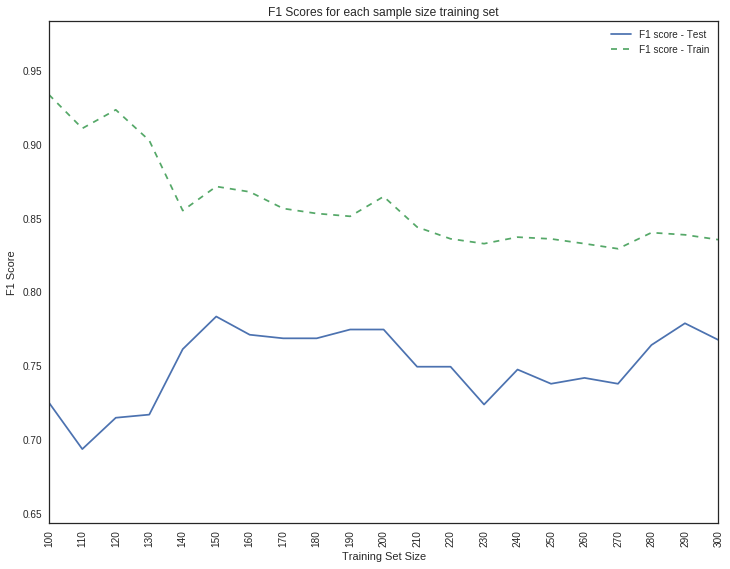

In [49]:
F1_plot(lr_stats)

The F1 score is more realistic on the training set as we get more data, probably due in part to the L1 regularization. 

The test set F1 score seems to be increasing and converging with the training set F1 score.

In [50]:
lr_model, _, _ = train_predict(LogisticRegression(penalty='l1'),
                               X_train_scaled, y_train,
                               X_test_scaled, y_test,
                               verbose=False)

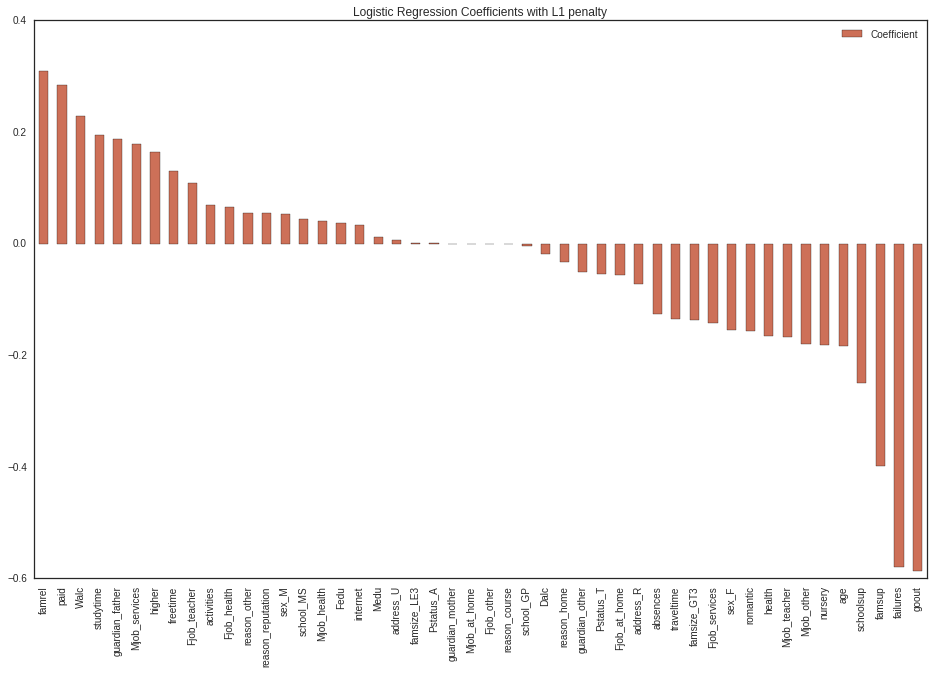

In [51]:
lr_coeffs = pd.DataFrame({'Feature': X_train.columns, 
                          'Coefficient': lr_model.coef_[0]}, 
                             index=X_train.columns)

lr_coeffs.sort_values(by='Coefficient', 
                      ascending=False).plot(kind='bar',
                                            figsize=(16, 10),
                                            color='#cd7058',
                                            title='Logistic Regression Coefficients with L1 penalty')

In [52]:
lr_coeffs.sort_values(by='Coefficient', ascending=False).head(4)

,Coefficient,Feature
famrel,0.309451,famrel
paid,0.283743,paid
Walc,0.228153,Walc
studytime,0.195562,studytime


Top 4 positively correlated features.

In [53]:
lr_coeffs.sort_values(by='Coefficient', ascending=False)[21:27]

,Coefficient,Feature
Pstatus_A,0.000729,Pstatus_A
guardian_mother,0.000000,guardian_mother
Mjob_at_home,0.000000,Mjob_at_home
Fjob_other,0.000000,Fjob_other
reason_course,0.000000,reason_course
school_GP,-0.003774,school_GP


Here we can see that indeed the L1 penalty has forced some feature weights to 0.

In [54]:
lr_coeffs.sort_values(by='Coefficient', ascending=False).tail(4)

,Coefficient,Feature
schoolsup,-0.250489,schoolsup
famsup,-0.397691,famsup
failures,-0.578631,failures
goout,-0.586473,goout


Top 4 negatively correlated features.

In [55]:
train_predict(LogisticRegression(penalty='l1'),
              X_train_scaled[['Medu', 'age', 'absences', 'failures']],
              y_train,
              X_test_scaled[['Medu', 'age', 'absences', 'failures']],
              y_test)
print "-"*42

Trained LogisticRegression...
Training time (secs): 0.0013
Predicted labels using LogisticRegression...
Prediction time (secs): 0.0042
Predicted labels using LogisticRegression...
Prediction time (secs): 0.0040
------------------------------------------
Training set size: 300
F1 score for training set: 0.816777041943
F1 score for test set: 0.811188811189
------------------------------------------


~~Here, we can train our logistic regression model using only these variables to convince ourselves that we do achieve approximately the same F1 scores on training and test sets.~~

## Fine-tune your model and report the best F1 score

## Decision Tree Tuning

In [93]:
labeled_f1_scorer = make_scorer(f1_score, pos_label='yes')

In [94]:
tree_params = {'criterion': ['gini', 'entropy'], # Default: Gini 
              'splitter': ['best', 'random'], # Default: 'best'
              'max_features': [None, 'auto', 'sqrt', 2, 5, 10, 15], # Default: None
              'max_depth': [None, 2, 3, 4, 5, 8], # Default: None
              'min_samples_split': [2, 10, 30, 60], # Default: 2
              'min_samples_leaf': [1, 2, 5, 10] # Default: 1
              }

In [95]:
tree_grid_search = GridSearchCV(estimator=DecisionTreeClassifier(),
                                param_grid=tree_params,
                                scoring=labeled_f1_scorer,
                                cv=5,
                                n_jobs=-1, # Use max amount of CPU cores available with -1,
                                verbose=1)

In [96]:
tree_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 2688 candidates, totalling 13440 fits


[Parallel(n_jobs=-1)]: Done 2072 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 12872 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 13440 out of 13440 | elapsed:   12.2s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'splitter': ['best', 'random'], 'min_samples_leaf': [1, 2, 5, 10], 'min_samples_split': [2, 10, 30, 60], 'criterion': ['gini', 'entropy'], 'max_features': [None, 'auto', 'sqrt', 2, 5, 10, 15], 'max_depth': [None, 2, 3, 4, 5, 8]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(f1_score, pos_label=yes), verbose=1)

In [97]:
tree_grid_search.best_score_

0.82394127700510678

In [98]:
tree_grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'max_features': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 60,
 'splitter': 'random'}

In [99]:
visualize_tree(tree_grid_search.best_estimator_, X_train.columns)

In [100]:
%%bash

dot -Tpng tree.dot -o tree.png

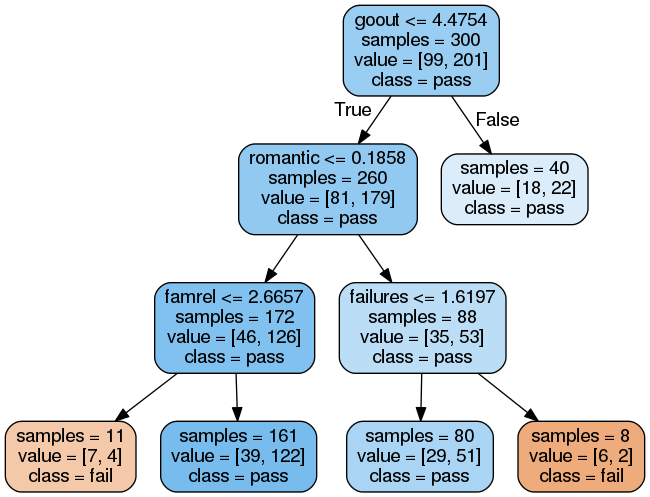

In [101]:
from IPython.display import Image
Image(filename='tree.png', width=920, height=1280)

In [163]:
dt_final, f1_dt_final, timing_dt_final = train_predict(DecisionTreeClassifier(**tree_grid_search.best_params_),
                                          X_train, y_train,
                                          X_test, y_test,
                                          verbose=False)

tree_tuned_stats = pd.DataFrame([f1_dt_final]).join(pd.DataFrame([timing_dt_final]))
tree_tuned_stats

,F1_test,F1_train,Predict_time_test,Predict_time_train,Training_time
0,0.8,0.823779,0.000115,0.000136,0.000521


---

## Random Forest Tuning

In [67]:
rf_params = {'criterion': ['gini', 'entropy'], # Default: 'gini'
              'max_features': ['auto', 3, 5, 10, 20, 30, 40], # Default: “auto” - sqrt(n_features)
              'max_depth': [None, 2, 4, 8, 12], # Default: None
              'n_estimators': [10, 50, 100, 500], #Default: 10
              }          

In [68]:
rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(),
                              param_grid=rf_params,
                              scoring=labeled_f1_scorer,
                              cv=5,
                              verbose=1,
                              n_jobs=-1 # Use max amount of CPU cores available with -1
                              )

In [69]:
rf_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 280 candidates, totalling 1400 fits


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 342 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 592 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 942 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1392 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1400 out of 1400 | elapsed:  1.6min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': ['auto', 3, 5, 10, 20, 30, 40], 'n_estimators': [10, 50, 100, 500], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 2, 4, 8, 12]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(f1_score, pos_label=yes), verbose=1)

In [70]:
rf_grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 20,
 'n_estimators': 100}

In [71]:
rf_importance_grid = pd.DataFrame({'Importance': rf_grid_search.best_estimator_.feature_importances_,
                                   'Feature': X_train.columns}).sort_values(by='Importance',
                                                                            ascending=False)
rf_importance_grid.head()

,Feature,Importance
47,absences,0.128782
32,failures,0.099391
43,goout,0.051883
4,age,0.043026
41,famrel,0.042367


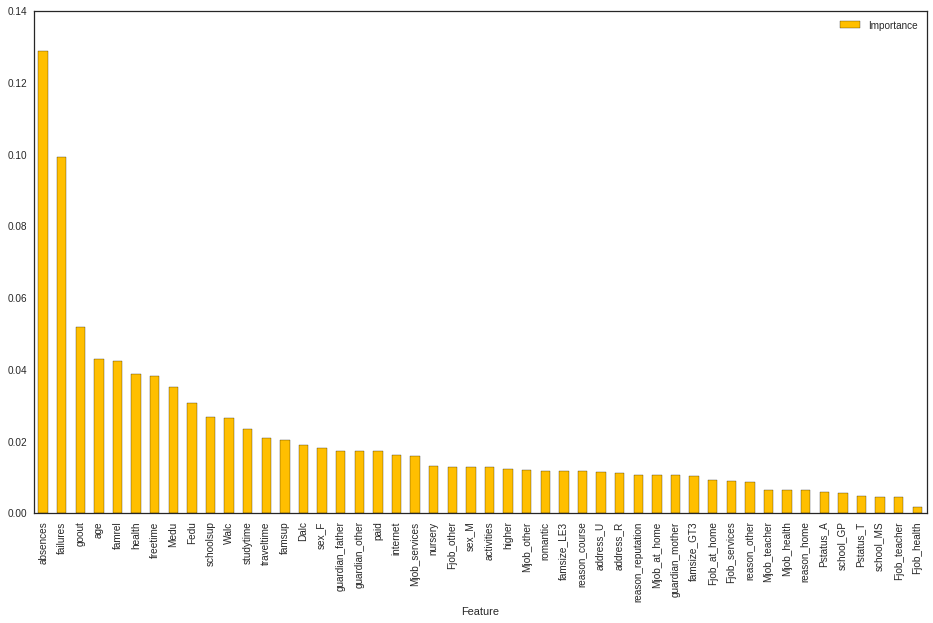

In [193]:
rf_importance_grid.index = rf_importance_grid.Feature
rf_importance_grid.plot(kind='bar', figsize=(16, 9), color='#ffbf00')

In [73]:
rf_grid_search.best_score_

0.82225271721460613

In [164]:
rf_final, f1_rf_final, rf_timing_final = train_predict(RandomForestClassifier(**rf_grid_search.best_params_),
                                                       X_train, y_train,
                                                       X_test, y_test,
                                                       verbose=False)

rf_tuned_stats = pd.DataFrame([f1_rf_final]).join(pd.DataFrame([rf_timing_final]))
rf_tuned_stats

,F1_test,F1_train,Predict_time_test,Predict_time_train,Training_time
0,0.811189,0.968675,0.004148,0.005533,0.15435


## Logistic Regression Tuning

In [104]:
small_range = np.linspace(0.2, 0.9, num=8)
small_range = [round(x, 2) for x in small_range]

lr_params = {'penalty': ['l1', 'l2'], # Default: 'l2'
             'C': [0.05] + [10**i for i in range(-3,3)] + small_range, # Default: 1
            }

In [105]:
lr_grid_search = GridSearchCV(estimator=LogisticRegression(),
                              param_grid=lr_params,
                              scoring=labeled_f1_scorer,
                              cv=5,
                              verbose=1,
                              n_jobs=-1 # Use max amount of CPU cores available with -1
                              )

In [106]:
lr_grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.0s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.05, 0.001, 0.01, 0.1, 1, 10, 100, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(f1_score, pos_label=yes), verbose=1)

In [107]:
lr_grid_search.best_params_

{'C': 0.1, 'penalty': 'l1'}

In [108]:
lr_grid_search.best_score_

0.82013066424374192

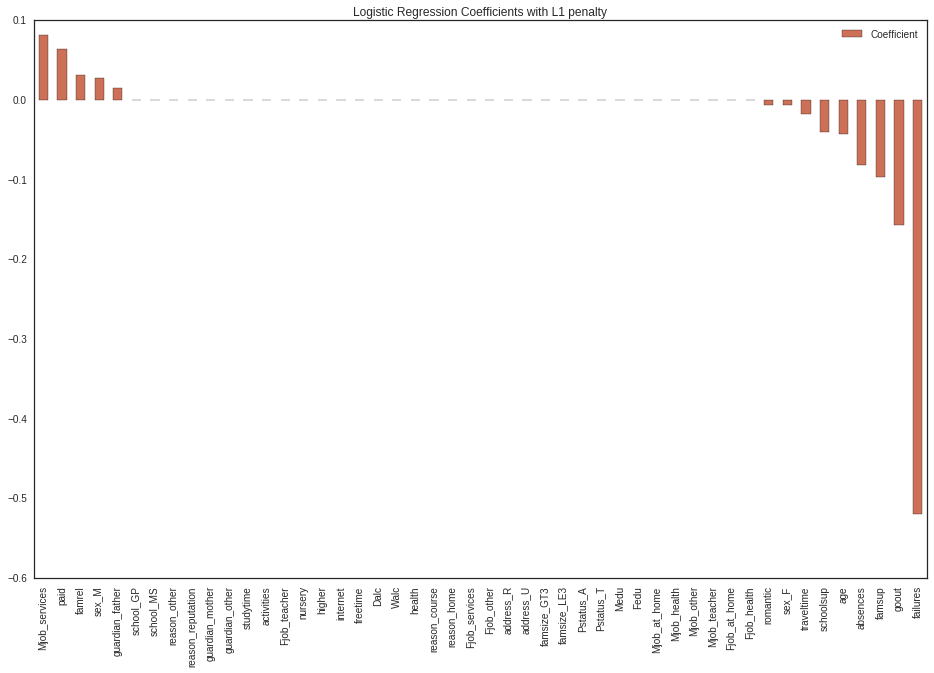

In [109]:
lr_coeffs_final = pd.DataFrame({'Feature': X_train.columns, 
                                'Coefficient': lr_grid_search.best_estimator_.coef_[0]},
                                index=X_train.columns)

lr_coeffs_final.sort_values(by='Coefficient', 
                            ascending=False).plot(kind='bar',
                                                  figsize=(16, 10),
                                                  color='#cd7058',
                                                  title='Logistic Regression Coefficients with L1 penalty')

In [165]:
lr_final, lr_F1_final, lr_timing_final = train_predict(LogisticRegression(**lr_grid_search.best_params_),
                                                       X_train_scaled, y_train,
                                                       X_test_scaled, y_test,
                                                       verbose=False)

lr_tuned_stats = pd.DataFrame([lr_F1_final]).join(pd.DataFrame([lr_timing_final]))
lr_tuned_stats

,F1_test,F1_train,Predict_time_test,Predict_time_train,Training_time
0,0.791946,0.828633,0.00007,0.000102,0.000982


---

## 5. Choosing the Best Model

- Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?
- In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).
- Fine-tune the model. Use Gridsearch with at least one important parameter tuned and with at least 3 settings. Use the entire training set for this.
- What is the model's final F<sub>1</sub> score?

In [182]:
tree_untuned_stats['Model'] = 'Decision Tree'
tree_untuned_stats['Tuning'] = 'Untuned'
rf_untuned_stats['Model'] = 'Random Forest'
rf_untuned_stats['Tuning'] = 'Untuned'
lr_untuned_stats['Model'] = 'Logistic Regression'
lr_untuned_stats['Tuning'] = 'Untuned'

tree_tuned_stats['Model'] = 'Decision Tree'
tree_tuned_stats['Tuning'] = 'Tuned'
rf_tuned_stats['Model'] = 'Random Forest'
rf_tuned_stats['Tuning'] = 'Tuned'
lr_tuned_stats['Model'] = 'Logistic Regression'
lr_tuned_stats['Tuning'] = 'Tuned'

In [183]:
final_stats = pd.concat([tree_untuned_stats, tree_tuned_stats,
                         rf_untuned_stats, rf_tuned_stats,
                         lr_untuned_stats, lr_tuned_stats],
                        axis=0)
final_stats.index = final_stats.Model.values
final_stats

,F1_test,F1_train,Model,Predict_time_test,Predict_time_train,Training_size,Training_time,Tuning
Decision Tree,0.740157,1.000000,Decision Tree,0.000118,0.000166,300,0.001393,Untuned
Decision Tree,0.800000,0.823779,Decision Tree,0.000115,0.000136,NaN,0.000521,Tuned
Random Forest,0.753623,0.992556,Random Forest,0.000587,0.000786,300,0.011522,Untuned
Random Forest,0.811189,0.968675,Random Forest,0.004148,0.005533,NaN,0.154350,Tuned
Logistic Regression,0.768116,0.836028,Logistic Regression,0.006087,0.002850,300,0.001926,Untuned
Logistic Regression,0.791946,0.828633,Logistic Regression,0.000070,0.000102,NaN,0.000982,Tuned


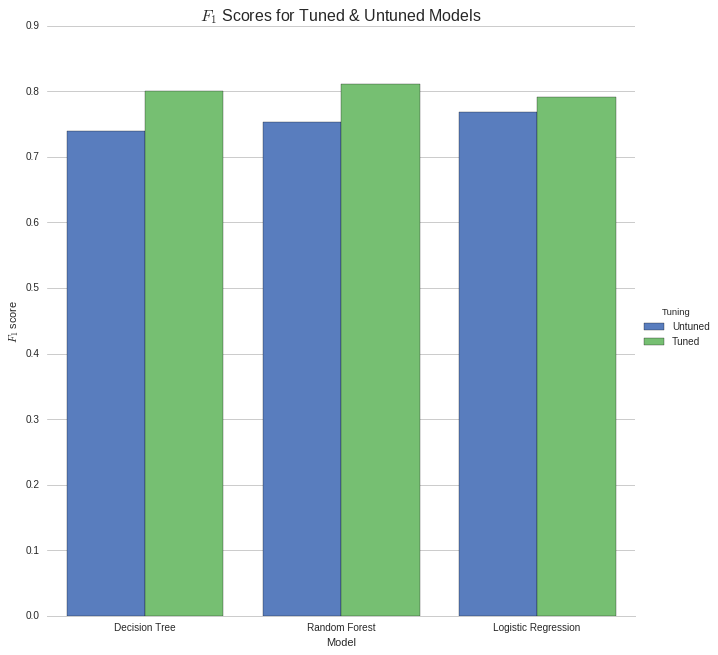

In [210]:
sns.set(style="whitegrid")
g = sns.factorplot(x='Model', y='F1_test',
                   hue='Tuning', data=final_stats, 
                   size=9, kind='bar',
                   palette='muted')

g.despine(left=True)
g.set_ylabels("$F_1$ score")
sns.plt.title('$F_1$ Scores for Tuned & Untuned Models', size=16)

sns.set(style="white")

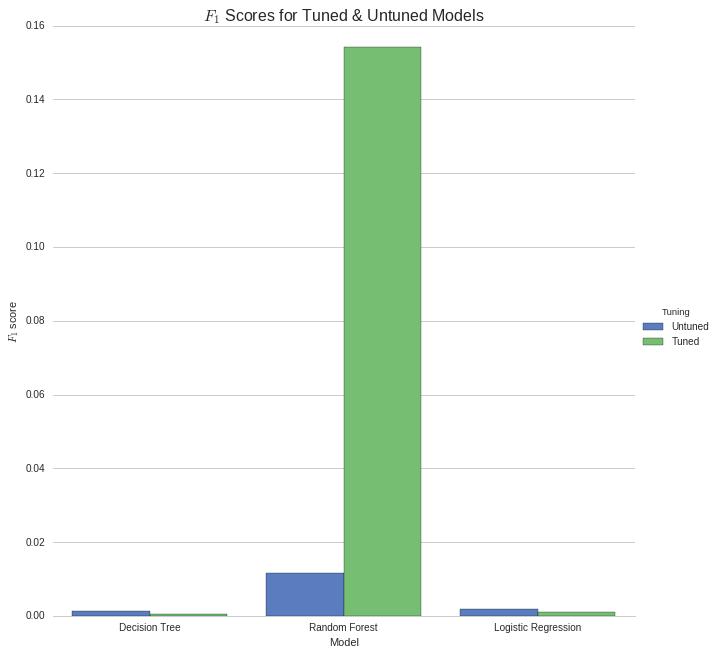

In [211]:
sns.set(style="whitegrid")
g = sns.factorplot(x='Model', y='Training_time',
                   hue='Tuning', data=final_stats, 
                   size=9, kind='bar',
                   palette='muted')

g.despine(left=True)
g.set_ylabels("$F_1$ score")
sns.plt.title('$F_1$ Scores for Tuned & Untuned Models', size=16)

sns.set(style="white")